# Infant Cry Classification

###  Case study analysis

1. The dataset is highly class-imbalanced - the class "hungry" is dramatically over-represented - this problem was tackled by creating a 'control' dataset.
2. The size of each sample is fairly low (approximately 100 kb) and recorded in 1 channel (mono), which is computationally less costly - I was planning to perform downsampling and accept the trade-off for the sound quality loss, but there was no need. 
3. The dataset has no negative samples (samples that don't correspond to baby cries), which will make the model unable to accurately perform on a foreign sound - This could be tackled by introducing samples from other noise types, but in order to keep the dataset fairly small and be on the safe side regarding computing times (as I am not familiar with sound processing and had no idea of the time I would need for model converging and hyper parameter optimization) I chose to deal only with the positive samples.
4. Curse of dimensionality: The number of features is higher than the number of samples by two orders of magnitude. A way of dealing with this could be adding more samples to the dataset (adding negative samples could be a solution).



## Dataset description

***"donateacry-corpus"*** :

For this project, we use the ***"donateacry-corpus"*** - an infant cry audio corpus built through the "Donate-a-cry" campaign (no longer active). Samples were donated by users via the Donate-a-cry mobile application for Android and iOS, and are in their original form.

***License:***

*The donateacry-corpus is made available under the Open Database License: http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/ - See more at: http://opendatacommons.org/licenses/odbl/#sthash.ejQJkkvi.dpuf*

***File naming convention***

The audio files are baby cry samples, with the corresponding tagging information encoded in the filenames. The samples were tagged by the contributors themselves. So here's how to parse the filenames.

```
iOS:
0D1AD73E-4C5E-45F3-85C4-9A3CB71E8856-1430742197-1.0-m-04-hu.caf
app instance uuid (36 chars)-unix epoch timestamp-app version-gender-age-reason
```
So, the above translates to:
- the sample was recorded with the app instance having the unique id 0D1AD73E-4C5E-45F3-85C4-9A3CB71E8856. These ids are generated upon installation, so they identify an installed instance, not a device or a user
- the recording was made at 1430742197 (unix time epoch) , which translates to Mon, 04 May 2015 12:23:17 GMT
- version 1.0 of the mobile app was used
- the user tagged the recording to be of a boy
- the baby is 0-4 weeks old according to the user
- the suspected reason of the cry is hunger

```
Android:
0c8f14a9-6999-485b-97a2-913c1cbf099c-1431028888092-1.7-m-26-sc.3gp
The structure is the same with the exception that the unix epoch timestamp is in milliseconds
```

### Tags
***Gender***
- *m* - male
- *f* - female

***Age***
- *04* - 0 to 4 weeks old
- *48* - 4 to 8 weeks old
- *26* - 2 to 6 months old
- *72* - 7 month to 2 years old
- *22* - more than 2 years old

***Reason***
- *hu* - hungry
- *bu* - needs burping
- *bp* - belly pain
- *dc* - discomfort
- *ti* - tired

#### ****Overview on the data distribution:****

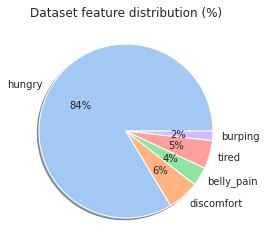

In [10]:
# overview figure of data distribution

import matplotlib.pyplot as plt
import seaborn as sns
import os

directory = "donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/"
cry_reasons = next(os.walk(directory))[1]

label_list = []
data_list = []

for folder in cry_reasons:
    label_data = (folder, len(next(os.walk(directory+folder))[2]))
    label = (label_data[0])
    data = (label_data[1])
    label_list.append(label)
    data_list.append(data)

colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data_list, labels = label_list, colors = colors, autopct='%.0f%%', shadow=True)
plt.title("Dataset feature distribution (%)")
plt.show()

### Data sample

Let us examine a sample. Python's library [Wave](https://docs.python.org/3/library/wave.html) allows us to process sound and extract characteristics like its frame rate, sampling frequency, audio duration or number of channels (mono/stereo). We choose a sample from the "belly pain" category, as example:

In [11]:
import wave
wav_obj = wave.open('donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav', 'rb')

# sampling frequency (no. of samples per second)
sample_freq = wav_obj.getframerate()
sample_freq

8000

In [12]:
# number of individual samples
n_samples = wav_obj.getnframes()
n_samples

54880

In [13]:
# duration of audio file (in seconds)
t_audio = n_samples/sample_freq
t_audio

6.86

In [14]:
# check if file was recorded in mono or stereo
n_channels = wav_obj.getnchannels()
n_channels # mono

1

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import glob
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

Text(0.5, 1.0, 'Raw audio')

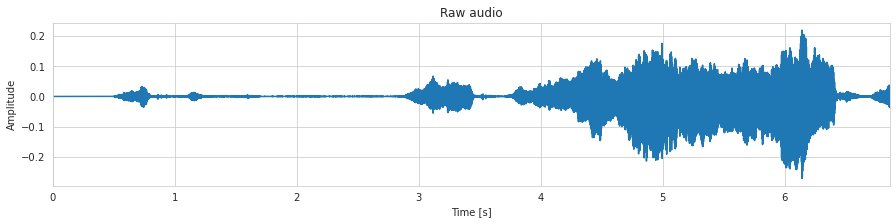

In [16]:
# Plot an example file
sample_file = "belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav"
fname = directory + sample_file
samples, sample_rate = librosa.load(fname)
max_time = samples.size / sample_rate
time_axis = np.linspace(0, max_time, samples.size)

fig, ax1 = plt.subplots(1, figsize=(15, 3))
ax1.plot(time_axis, samples)
ax1.set_xlim([time_axis.min(), time_axis.max()])
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Time [s]")
ax1.set_title("Raw audio")

/tmp/ipykernel_91041/9135792.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
/tmp/ipykernel_91041/9135792.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax=ax[1], format="%+2.0f dB")


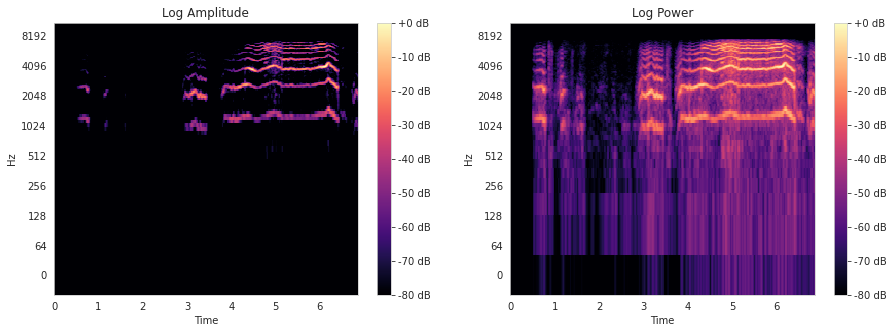

In [17]:
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='log',sr=sample_rate, x_axis='time', ax=ax[0])
ax[0].set_title('Log Amplitude')
fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
img = librosa.display.specshow(librosa.power_to_db(S,ref=np.max), y_axis='log',sr=sample_rate, x_axis='time', ax=ax[1])
ax[1].set_title('Log Power')
fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
plt.show()

### Data preparation and pre-processing
Given that the classifiers used in this project are not suited for temporal tasks, we will treat the audio data as a 2D-image. For simplicity, and given the sample data plotted above, we choose to focus the analysis on the spectral power of each audio sample (in dB). Furthermore, for appropriate comparisons, the samples are scaled and centered.

In [18]:
# 1) Load audio samples:
labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
dataset_power_scaled = {k: [] for k in labels}

for k in labels:
    print("Loading and preprocessing {} data".format(k))
    files = glob.glob(directory + "{}/*".format(k))
    for fname in tqdm(files):
        samples, sample_rate = librosa.load(fname)
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        scaler = MinMaxScaler()
        dataset_power_scaled[k].append(scaler.fit_transform(librosa.power_to_db(S, ref=np.max)).flatten())

Loading and preprocessing belly_pain data


100%|██████████| 16/16 [00:01<00:00, 12.85it/s]


Loading and preprocessing burping data


100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Loading and preprocessing discomfort data


100%|██████████| 27/27 [00:02<00:00, 10.61it/s]


Loading and preprocessing hungry data


100%|██████████| 382/382 [00:30<00:00, 12.38it/s]


Loading and preprocessing tired data


100%|██████████| 24/24 [00:01<00:00, 12.94it/s]


In [19]:
# 2) build a usable dataset: using the dataset as is

# 2.1) concatenate dataset
total_samples = np.sum([len(x) for x in dataset_power_scaled.values()])
concatenated_data = np.zeros((40000, total_samples))  # choose 40k features to cover all data lengths in the dataset (will be zero-padded)
label_sequence = []
ctr = 0
for k, v in dataset_power_scaled.items():
    for sample in v:
        label_sequence.append(k)
        concatenated_data[:sample.shape[0], ctr] = sample
        ctr += 1

# 2.2) create labels (one-hot encoded)
y = np.zeros((np.unique(label_sequence).shape[0], total_samples))
for idx, lab in enumerate(label_sequence):
    y[np.where(lab == np.unique(label_sequence))[0][0], idx] = 1.

# 2.3) randomize samples (because they were read from the dictionary they are ordered by label)
indices = np.random.permutation(total_samples)
X = concatenated_data[:, indices]
label_sequence = np.array(label_sequence)[indices]
y = y[:, indices]

**Note:** Given the drammatic class imbalance in the dataset, we will extend the analysis to include a modified version, where labels and samples are randomized. This is done to compare the case where the classes are balanced, but it introduces additional problems, namely repeated samples in both training and testing. Nevertheless, given the dataset we are working with, the only valid alternatives would be to engineer new samples and rebalance the classes, but this would introduce additional biases. 

In [20]:
# 3) build a (control) usable dataset: using permutations of the dictionary elements 

# a) how many total samples to we have? 
total_samples = np.sum([len(x) for x in dataset_power_scaled.values()])

# b) create a random sequence
label_sequence_control = np.random.choice(labels, size=total_samples)

# c) sample dataset
X_control = np.zeros((40000, total_samples))
for idx, k in enumerate(label_sequence_control):
    smp = np.random.choice(dataset_power_scaled[k], 1)[0]
    X_control[:smp.shape[0], idx] = smp

# d) create labels (one-hot encoded)
y_control = np.zeros((np.unique(label_sequence_control).shape[0], total_samples))
for idx, lab in enumerate(label_sequence_control):
    y_control[np.where(lab == np.unique(label_sequence_control))[0][0], idx] = 1.

/tmp/ipykernel_91041/3104480117.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smp = np.random.choice(dataset_power_scaled[k], 1)[0]


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.25)

In [22]:
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control.T, y_control.T, test_size=0.25)

## Technique

### Motivation for choosing the technique and provide a schematic figure of the process


**Multilayer Perceptron**

There are already some studies over the donateacry-corpus dataset, mostly done with CNNs - Convolutional Neural Networks. CNNs are a type of deep learning algorithm that perform really well at learning images, since "they can learn patterns that are translation invariant and have spatial hierarchies" (F. Chollet, 2018).

Although CNNs are best suited for image processing, they can be used on audio datasets, since audio can be represented as an image-like format and fed to the network - this is when the concept of a ***melspectrogram*** - a visual spectrum representation of a Mel Scale (y-axis) over time (x-axis) - comes into place.

To avoid the pitfall of repeating in some way the found studies, one of the two techniques I chose is a ***MLP (Multilayer Perceptron)*** which is provided by ScikitLearn (MLPClassifier).

MLP solves the issue of tackling more convoluted problems that are not linearly separable, by linking multiple perceptrons together (Haykin, 1994).

A multilayer perceptron can be naively thought of as using higher layers to combine lower level decision boundaries, which are linear, into more complex non-linear ones.

***Schematic figure of baby cries classification with a MLP :***

The following figure illustrates how a MLP classifies a given audio input into one of the possible five outputs.

Melspectrograms for each audio sample are received by the MLP's input layer(s) - an arbitrary number of hidden layers that are placed in between the input and output layer, and the classification task is performed by the output layer. The neurons in the MLP are trained with a back propagation algorithm.

![title](mlp.png)

#### Sound and Melspectrograms:

***Melspectrograms :***

A melspectrogram is a way to visually represent a signal’s amplitude over time at different frequencies. For the creation of a Melspectrogram we'll be using [Librosa](https://librosa.org/doc/latest/index.html), as it is built specifically for dealing with audio files and turns the processing easier:

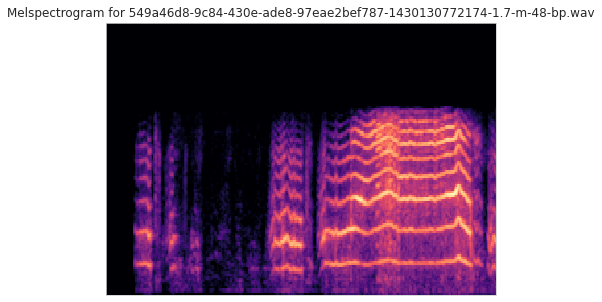

In [23]:
# Representation of a melspectrogram for one random sample

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fname = 'donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav'
samples, sample_rate = librosa.load(fname)

fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Melspectrogram for 549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav')
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))


- Why the use of a Fourier Transform?

An audio signal is comprised of several single-frequency sound waves. When taking samples of the signal over time, we only capture the resulting amplitudes. The Fourier transform is a mathematical formula that allows us to decompose a signal into its individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum.

***Schematics for a Fourier Transform in an audio signal:***

![Fourier Transform](https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png)

Image credits: https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png

### Setting hyper parameters


MLPs have several important hyperparameters. Below we briefly describe them and motivate our initial intuition:
- Network size: number of layers and units per layer. Given the input dimensionality (40k), our initial choice for network size will be a single layer (as we mainly wish to project the data to a higher dimensional space) with >40k dimensions. For computational reasons, the example below will be run with default parameters though (these will be optimized below).
- Transfer function: unit nonlinearity. As an initial choice, a `tanh` provides a smoother unit I/O which can help the output layer make reasonable classifications
- Solver: gradiend descent optimizer. We will initialize the model with the ADAM algorithm, as its adaptive learning rate and step size is more flexible than the alternatives
- Alpha: L2-norm, i.e. the penalty on the magnitude of the output coefficients. We choose an initial small value to give the model some flexibility
- Learning rate: self-explanatory. We will initialize with a reasonably large learning rate for faster convergence

In [24]:
from sklearn.neural_network import MLPClassifier
clf1 = MLPClassifier(activation="tanh", solver="adam", alpha=1e-3, learning_rate="adaptive", random_state=1, max_iter=300)
clf1.fit(X_train, y_train)
clf1.score(X_test, y_test)

8.608695652173913e-01

### Optimising hyper parameters


We will perform a guided hyperparameter optimization using `optuna`. The cell below is computationally costly, so ran it offline and stored the data, which will be loaded and analyzed in the cell below.

In [25]:
'''import optuna
from joblib import parallel_backend

def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 1000, log=True))

    hyperparameters = {
        'hidden_layer_sizes': tuple(layers),
        'activation': trial.suggest_categorical("activation", ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical("solver", ['lbfgs', 'sgd', 'adam']),
        'alpha': trial.suggest_float("alpha", 1e-5, 1., log=True),
        'learning_rate': trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive'])
    }
    with parallel_backend('threading', n_jobs=32):
        clf = MLPClassifier(**hyperparameters, max_iter=1000)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
    return score

study_name = "MLP_optune2"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=100)'''

'import optuna\nfrom joblib import parallel_backend\n\ndef objective(trial):\n    n_layers = trial.suggest_int(\'n_layers\', 1, 4)\n    layers = []\n    for i in range(n_layers):\n        layers.append(trial.suggest_int(f\'n_units_{i}\', 1, 1000, log=True))\n\n    hyperparameters = {\n        \'hidden_layer_sizes\': tuple(layers),\n        \'activation\': trial.suggest_categorical("activation", [\'identity\', \'logistic\', \'tanh\', \'relu\']),\n        \'solver\': trial.suggest_categorical("solver", [\'lbfgs\', \'sgd\', \'adam\']),\n        \'alpha\': trial.suggest_float("alpha", 1e-5, 1., log=True),\n        \'learning_rate\': trial.suggest_categorical("learning_rate", [\'constant\', \'invscaling\', \'adaptive\'])\n    }\n    with parallel_backend(\'threading\', n_jobs=32):\n        clf = MLPClassifier(**hyperparameters, max_iter=1000)\n        clf.fit(X_train, y_train)\n        score = clf.score(X_test, y_test)\n    return score\n\nstudy_name = "MLP_optune2"  # Unique identifier of 

In [28]:
import optuna

study_name = "MLP_optune2"  
storage_name = "sqlite:///{}.db".format(study_name)
loaded_study_clf1 = optuna.load_study(study_name=study_name, storage=storage_name)
print("Best result:")
loaded_study_clf1.best_params, loaded_study_clf1.best_value

Best result:


({'activation': 'relu',
  'alpha': 0.36046408755917786,
  'learning_rate': 'adaptive',
  'n_layers': 4,
  'n_units_0': 4,
  'n_units_1': 11,
  'n_units_2': 4,
  'n_units_3': 1,
  'solver': 'sgd'},
 0.8211920529801324)

In [29]:
clf1_best_params = loaded_study_clf1.best_params
clf1_best_params = loaded_study_clf1.best_params
clf1_best_params.update({'hidden_layer_sizes': (4, 4, 11, 4, 1)})
clf1_best_params.pop("n_layers")
clf1_best_params.pop("n_units_0")
clf1_best_params.pop("n_units_1")
clf1_best_params.pop("n_units_2")
clf1_best_params.pop("n_units_3")

1

/tmp/ipykernel_91041/906593220.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(loaded_study_clf1)


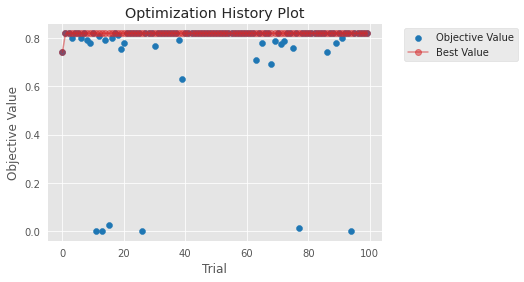

In [30]:
fig = optuna.visualization.matplotlib.plot_optimization_history(loaded_study_clf1)

In [31]:
study_name = "MLP_optune"  # Control study (balanced classes)
storage_name = "sqlite:///{}.db".format(study_name)
loaded_study_clf1_control = optuna.load_study(study_name=study_name, storage=storage_name)
print("Best result:")
loaded_study_clf1_control.best_params, loaded_study_clf1_control.best_value

Best result:


({'activation': 'tanh',
  'alpha': 0.014935637305896032,
  'learning_rate': 'adaptive',
  'n_layers': 2,
  'n_units_0': 369,
  'n_units_1': 10,
  'solver': 'lbfgs'},
 0.9536423841059603)

In [32]:
clf1_best_params_control = loaded_study_clf1_control.best_params
clf1_best_params_control.update({'hidden_layer_sizes': (369, 10)})
clf1_best_params_control.pop("n_layers")
clf1_best_params_control.pop("n_units_0")
clf1_best_params_control.pop("n_units_1")

10

/tmp/ipykernel_91041/3746648570.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(loaded_study_clf1_control)


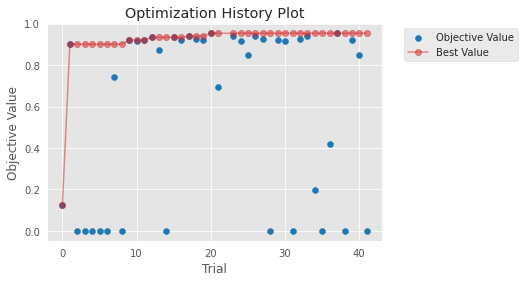

In [33]:
fig = optuna.visualization.matplotlib.plot_optimization_history(loaded_study_clf1_control)

### Performance metrics for training

Training is done to minimize the log-loss. Performance metrics will be based on raw classification accuracy.  
Both testing and hyperparameter tuning will aim to maximize classification accuracy.

Test_accuracy:


/home/neuro/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8608695652173913

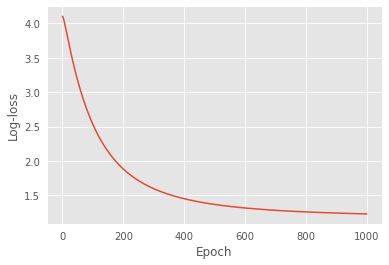

In [34]:
clf1 = MLPClassifier(max_iter=1000, **clf1_best_params)
clf1.fit(X_train, y_train)
fig, ax = plt.subplots()
ax.plot(clf1.loss_curve_)
ax.set_xlabel("Epoch")
ax.set_ylabel("Log-loss")

print("Test_accuracy:")
clf1.score(X_test, y_test)

In [35]:
clf1_control = MLPClassifier(max_iter=1000, **clf1_best_params_control)
clf1_control.fit(X_train_control, y_train_control)

/home/neuro/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', alpha=0.014935637305896032,
              hidden_layer_sizes=(369, 10), learning_rate='adaptive',
              max_iter=1000, solver='lbfgs')

**Support Vector Machine with multiclass classification**

The motivation for choosing this algorithm is because we are treating this dataset as a collection of images with features that are not linearly separable. As such, a kernel-based approach is suitable to resolve spatial ambiguities.
The obvious solution would be spatial pooling via convolution (CNNs), but since this has not been covered during the Machine Learning module, we decided to avoid it.

SVM classification is based on projecting the input space to a richer higher dimensional feature space via a kernel - *kernel trick*. The kernel is a hyperparameter of the model - in simple problems it can be *linear*, but we will explore several variants. 

The Support Vector Machine is fundamentally a two-class classifier. In this case, however, we are dealing with a multilabel classification problem (K=5 classes). There are several methods for combining multiple two-class SVMs in order to build a multiclass classifier.

We'll be using a ***one-versus-the-rest*** approach:

"construct K separate SVMs in which the kth model yk(x) is trained using the data from class Ck as the positive examples and the data from the remaining K-1 classes as the negative examples." ***(MLA. Bishop, Christopher M. Pattern Recognition and Machine Learning. New York :Springer, 2006.)***

I made the following illustration to explain kernel trick and one-vs-all in SVMs, in this project in particular:

![](svms.jpeg)

### Setting hyper parameters (rationale)


The hyperparameters of interest for the SVM are:
- L2-Regularization: maintain the Euclidean norm of the coefficients (support vectors) small. We will initialize with a small penalty for flexibility
- Kernel: input to feature space mapping functional. We will initialize with a nonlinear kernel, e.g. sigmoid, given the large class overlap in the dataset

In [36]:
from sklearn.svm import SVC
clf2 = SVC(C=1e-5, kernel="sigmoid")
clf2.fit(X_train, np.argmax(y_train, 1))
clf2.score(X_test, np.argmax(y_test, 1))

0.8608695652173913

### Optimising hyper parameters


We will perform a guided hyperparameter optimization using `optuna`. The cell below is computationally costly, so ran it offline and stored the data, which will be loaded and analyzed in the cell below.

In [37]:
"""import optuna
from joblib import parallel_backend

def objective(trial):

    hyperparameters = {
        'C': trial.suggest_float("C", 1e-5, 1.0, log=True),
        'kernel': trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),}

    with parallel_backend('threading', n_jobs=32):
        clf = SVC(**hyperparameters)
        clf.fit(X_train, np.argmax(y_train, 1))
        score = clf.score(X_test, np.argmax(y_test, 1))
    return score

study_name = "SVC_optune2"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="maximize")
study.optimize(objective, n_trials=100)"""

'import optuna\nfrom joblib import parallel_backend\n\ndef objective(trial):\n\n    hyperparameters = {\n        \'C\': trial.suggest_float("C", 1e-5, 1.0, log=True),\n        \'kernel\': trial.suggest_categorical("kernel", [\'linear\', \'poly\', \'rbf\', \'sigmoid\']),}\n\n    with parallel_backend(\'threading\', n_jobs=32):\n        clf = SVC(**hyperparameters)\n        clf.fit(X_train, np.argmax(y_train, 1))\n        score = clf.score(X_test, np.argmax(y_test, 1))\n    return score\n\nstudy_name = "SVC_optune2"  # Unique identifier of the study.\nstorage_name = "sqlite:///{}.db".format(study_name)\nstudy = optuna.create_study(study_name=study_name, storage=storage_name, direction="maximize")\nstudy.optimize(objective, n_trials=100)'

In [38]:
study_name = "SVC_optune2"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
loaded_study_clf2 = optuna.load_study(study_name=study_name, storage=storage_name)
print("Best result:")
loaded_study_clf2.best_params, loaded_study_clf2.best_value

Best result:


({'C': 0.0031619723298809887, 'kernel': 'linear'}, 0.8278145695364238)

In [39]:
clf2_best_params = loaded_study_clf2.best_params

In [40]:
study_name = "SVC_optune"  # control dataset
storage_name = "sqlite:///{}.db".format(study_name)
loaded_study_clf2_control = optuna.load_study(study_name=study_name, storage=storage_name)
print("Best result:")
loaded_study_clf2_control.best_params, loaded_study_clf2_control.best_value

Best result:


({'C': 0.7144193880760347, 'kernel': 'poly'}, 0.9602649006622517)

In [41]:
clf2_best_params_control = loaded_study_clf2_control.best_params

### Performance metrics for training

Performance will be assessed using the raw classification accuracy.

In [42]:
clf2 = SVC(**clf2_best_params)
clf2.fit(X_train, np.argmax(y_train, 1))
print("Test_accuracy:")
clf2.score(X_test, np.argmax(y_test, 1))

Test_accuracy:


0.8521739130434782

In [43]:
clf2_control = SVC(**clf2_best_params_control)
clf2_control.fit(X_train_control, np.argmax(y_train_control, 1))
print("Test_accuracy:")
clf2_control.score(X_test_control, np.argmax(y_test_control, 1))

Test_accuracy:


0.9565217391304348

## Comparison of metrics performance for testing 

### a) Examining over-fitting

The structure of the dataset is particularly prone to over-fitting. Apart from the drammatic class imbalance, the way we treat the dataset (as 2D images, rather than spectrotemporal timeseries) gives rise to a 40k-dimensional feature space and a total of approximately 400 samples. This falls within the definition of the well-known problem "the curse of dimensionality". These two problems will give rise to drammatic over-fitting. We did not explicitly measure the effect (could be performed, e.g., by measuring accuracy on a hold-out validation set), but the likelihood of over-fitting is extremely high, given the characteristics of the dataset.

### b) Comparison with appropriate metrics for testing

Below, we compare the test accuracies for the 2 methods employed in this study. In addition, as explained above, we include one *control* condition, where we compensate for class imbalance by randomizing the data samples. These results are also included for completeness.

In [44]:
import pandas as pd
accuracies = {
    "MLP": [clf1.score(X_test, y_test)],
    "MLP_control": [clf1_control.score(X_test_control, y_test_control)],
    "SVM": [clf2.score(X_test, np.argmax(y_test, 1))],
    "SVM_control": [clf2_control.score(X_test_control, np.argmax(y_test_control, 1))]
}
acc = pd.DataFrame(accuracies)
acc

,MLP,MLP_control,SVM,SVM_control
0,0.86087,0.86087,0.852174,0.956522


<AxesSubplot:>

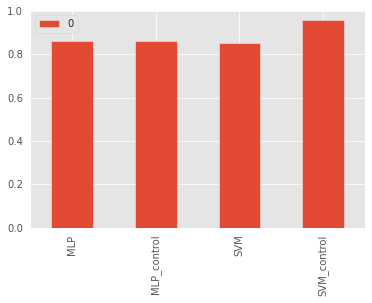

In [45]:
acc.T.plot.bar()

Additionally, and given that we have a 1-month old baby at home, we further evaluate model accuracy in predicting the labels for 1 sample cry where the baby was displaying `discomfort`.

/tmp/ipykernel_91041/2401200552.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
/tmp/ipykernel_91041/2401200552.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax=ax[1], format="%+2.0f dB")


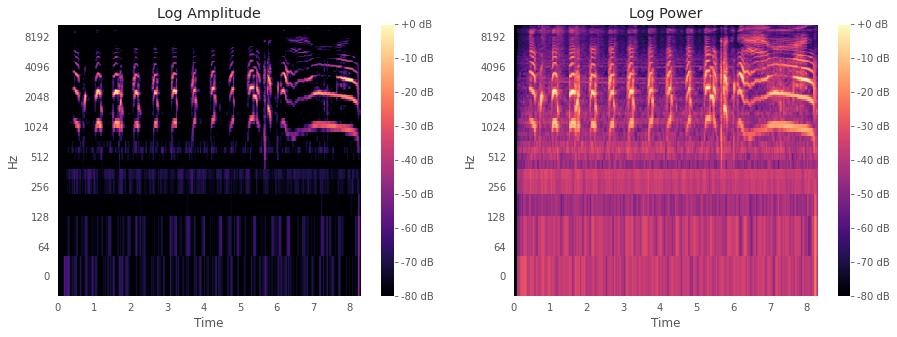

In [46]:
fname = "sample1.wav"
samples, sample_rate = librosa.load(fname)
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='log',sr=sample_rate, x_axis='time', ax=ax[0])
ax[0].set_title('Log Amplitude')
fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
img = librosa.display.specshow(librosa.power_to_db(S,ref=np.max), y_axis='log',sr=sample_rate, x_axis='time', ax=ax[1])
ax[1].set_title('Log Power')
fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
plt.show()

In [47]:
new_data = librosa.amplitude_to_db(S, ref=np.max).flatten()
scaler = MinMaxScaler()
new_data_scaled = scaler.fit_transform(librosa.amplitude_to_db(S, ref=np.max)).flatten()

np.array([new_data_scaled]).shape
dd = np.zeros((40000, 1))
if new_data_scaled.shape[0] < 40000:
    dd[:new_data_scaled.shape[0], 0] = new_data_scaled
else:
    dd[:, 0] = new_data_scaled[:40000]

In [48]:
clf1.predict(dd.T)

array([[0, 0, 0, 1, 0]])

In [49]:
clf1_control.predict(dd.T)

array([[0, 0, 1, 0, 0]])

In [50]:
clf2.predict(dd.T)

array([3])

In [51]:
clf2_control.predict(dd.T)

array([3])

### c) Model selection

Although the performances of both MLP and SVM are reasonable (more than 80% both in the control study and in the original dataset), SVM seems to perform better when we simulate a balanced dataset, reaching a performance of 95%. Given these results, a SVM seems to be a more appropriate choice to classify the baby cries.

## Final recommendation of best model

MLP is a more complex algorithm, as for example it has more hyperparameters, which have an impact on the model's size, making it less efficient.

SVMs typically have higher prediction accuracy than a multilayer perceptron. SVMs (may) though have higher runtime because they perform advanced computations, such as translating n-dimensional space using kernel functions. But in general, their results are quite good.

SVMs aim to minimise structural risk, while MLP classifiers perform empirical risk minimization. Therefore, SVMs are efficient and provide near-optimal classification by obtaining the optimal separation surface that works well for previously unseen data points.

These give no surprise to the results we obtained, having a much longer computational runtime on the SVM than on the MLP, but more satisfactory results.